In [ ]:
import os
import time
import numpy as np
import torch
from datasets import load_dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_recall_fscore_support,accuracy_score,classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
MODEL_NAME="roberta-base" 
OUTPUT_DIR="checkpoints_4/goemotions_transfer" 

#result of the cross dataset's parameter's selection
NUM_EPOCHS=4
BATCH_SIZE=16
LR=2.2822861897747952e-05 
WEIGHT_DECAY = 0.09833242829202182
MAX_LENGTH = 128
THRESHOLD = 0.5  
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
dataset=load_dataset("go_emotions")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [4]:
num_labels=dataset["train"].features["labels"].feature.num_classes
num_labels

28

In [5]:
info=dataset["train"].features["labels"].feature.names
info

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [6]:
for i,j in enumerate(info):
    print(i,j)

0 admiration
1 amusement
2 anger
3 annoyance
4 approval
5 caring
6 confusion
7 curiosity
8 desire
9 disappointment
10 disapproval
11 disgust
12 embarrassment
13 excitement
14 fear
15 gratitude
16 grief
17 joy
18 love
19 nervousness
20 optimism
21 pride
22 realization
23 relief
24 remorse
25 sadness
26 surprise
27 neutral


In [7]:
mlb=MultiLabelBinarizer(classes=list(range(num_labels)))

In [8]:
dataset["train"]["labels"]

Column([[27], [27], [2], [14], [3]])

In [9]:

tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME)
num_labels=dataset["train"].features["labels"].feature.num_classes

#fit MultiLabelBinarizer
train_label_lists = [list(lbls) for lbls in dataset["train"]["labels"]]
mlb = MultiLabelBinarizer()
mlb.fit(train_label_lists)

print(f"MLB classes_ length: {len(mlb.classes_)}")

#preprocessing function
def preprocess(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=MAX_LENGTH,
    )

    # encode labels->multi-hot
    batch_label_lists = [list(lbls) for lbls in examples["labels"]]
    multi_hot = mlb.transform(batch_label_lists).astype(float).tolist()
    tokenized["labels"] = multi_hot
    # print(multi_hot)
    return tokenized

# --- apply preprocessing ---
tokenized = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)


MLB classes_ length: 28


Map: 100%|██████████| 5427/5427 [00:00<00:00, 17777.82 examples/s]


In [10]:
mlb.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [11]:
list(dataset["train"]["labels"][0])[0]

27

In [12]:
print("Example transformed label (first train sample):", mlb.transform([list(dataset["train"]["labels"][0])])[0])
# After mapping:
print(tokenized["train"].features)
# Peek at a sample
print(tokenized["train"][0]["labels"][:10])  # first few entries of the multi-hot vector


Example transformed label (first train sample): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
{'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
# Ensure input_ids/attention_mask are int64 and labels are float32
#this is very important as this gives error because MultiLabelBinarizer require float value for the labes but map function before convert it in int
cast_features = Features({
    "input_ids": Sequence(Value("int64")),
    "attention_mask": Sequence(Value("int64")),
    "labels": Sequence(Value("float32"))
})
tokenized["train"]=tokenized["train"].cast(cast_features)
if "validation" in tokenized:
    tokenized["validation"]=tokenized["validation"].cast(cast_features)
if "test" in tokenized:
    tokenized["test"]=tokenized["test"].cast(cast_features)

print(tokenized["train"].features)

print("Preparing model with multi-label configuration...")
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels, problem_type="multi_label_classification")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
print("Model problem_type:", model.config.problem_type, " num_labels:", model.config.num_labels)

Casting the dataset: 100%|██████████| 5427/5427 [00:00<00:00, 186698.66 examples/s]


{'input_ids': List(Value('int64')), 'attention_mask': List(Value('int64')), 'labels': List(Value('float32'))}
Preparing model with multi-label configuration...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model problem_type: multi_label_classification  num_labels: 28


In [14]:
print("Preparing model with multi-label configuration...")
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels, problem_type="multi_label_classification")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model.to(DEVICE)
print("Model problem_type:", model.config.problem_type, " num_labels:", model.config.num_labels)


Preparing model with multi-label configuration...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model problem_type: multi_label_classification  num_labels: 28


In [15]:
hf_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def multilabel_data_collator(features):
    """
    Accepts a list of examples (dicts). Returns a batch dict where:
     - inputs are padded via HF collator
     - labels is torch.FloatTensor of shape (B, num_labels) dtype float32
    """
    batch = hf_collator(features)  # pads input_ids/attention_mask/etc.
    # Build labels tensor from raw features
    labels = [f["labels"] for f in features]
    labels = torch.tensor(labels, dtype=torch.float32)
    batch["labels"] = labels
    return batch

In [16]:
def compute_metrics(eval_pred):
    """
    eval_pred: tuple (logits, labels) where both are numpy arrays (as provided by Trainer).
    This computes micro/macro F1, macro precision/recall and exact-match accuracy.
    """
    logits, labels = eval_pred  # numpy arrays
    # convert logits -> probs via sigmoid (NumPy)
    probs = 1 / (1 + np.exp(-logits))
    # threshold to get binary predictions
    preds = (probs >= THRESHOLD).astype(int)
    # ensure labels are int arrays (they might be float32)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)  
    return {
        "accuracy": acc,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "macro_precision": p,
        "macro_recall": r,
    }

In [17]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=0.01,
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",  # matches compute_metrics return key
    save_total_limit=3,
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=multilabel_data_collator,
    compute_metrics=compute_metrics,
)


C:\Users\Raj Aryan\AppData\Local\Temp\ipykernel_23096\2798730941.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
start_time=time.time()
trainer.train()
train_time=time.time()-start_time
print(f"Training completed in {train_time/60:.2f} minutes")

#Evaluate
print("Running final evaluation...")
eval_results = trainer.evaluate()
print("Eval results:", eval_results)


#Save
final_dir = os.path.join(OUTPUT_DIR, "final_model")
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
trainer.state.save_to_json(os.path.join(final_dir, "trainer_state.json"))
if trainer.optimizer is not None:
    torch.save(trainer.optimizer.state_dict(), os.path.join(final_dir, "optimizer.pt"))
if trainer.lr_scheduler is not None:
    torch.save(trainer.lr_scheduler.state_dict(), os.path.join(final_dir, "scheduler.pt"))

print(f"Saved final model to {final_dir}")


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Macro F1,Macro Precision,Macro Recall
1,0.094600,0.090983,0.412827,0.537445,0.342916,0.493008,0.301531
2,0.081600,0.083958,0.443236,0.564416,0.409969,0.589353,0.347268
3,0.073400,0.082999,0.466642,0.581220,0.439607,0.565886,0.381371
4,0.068600,0.084020,0.472355,0.586333,0.453073,0.540779,0.408571


Training completed in 19.09 minutes
Running final evaluation...


Eval results: {'eval_loss': 0.08402012288570404, 'eval_accuracy': 0.47235532620715076, 'eval_micro_f1': 0.5863331844573471, 'eval_macro_f1': 0.45307274286379334, 'eval_macro_precision': 0.5407793087887972, 'eval_macro_recall': 0.4085709425716496, 'eval_runtime': 5.7886, 'eval_samples_per_second': 937.367, 'eval_steps_per_second': 58.737, 'epoch': 4.0}
Saved final model to checkpoints_4/goemotions_transfer\final_model


In [19]:
print("Measuring inference latency on validation set...")
eval_dataloader = trainer.get_eval_dataloader()
model.eval()
total_time = 0.0
total_samples = 0
with torch.no_grad():
    for batch in eval_dataloader:
        # move inputs to device but not labels (we only time forward pass)
        inputs = {k: v.to(DEVICE) for k, v in batch.items() if k in ("input_ids", "attention_mask")}
        b_start = time.time()
        _ = model(**inputs)
        b_end = time.time()
        batch_time = b_end - b_start
        batch_size = batch["input_ids"].shape[0]
        total_time += batch_time
        total_samples += batch_size

avg_latency_ms = (total_time / total_samples) * 1000 if total_samples else float("nan")
throughput = total_samples / total_time if total_time > 0 else 0
print(f"Avg inference latency per sample: {avg_latency_ms:.2f} ms")
print(f"Throughput (samples/sec): {throughput:.2f}")

print("All done. Baseline model & artifacts are saved. You can now proceed to transfer experiments.")

Measuring inference latency on validation set...
Avg inference latency per sample: 0.74 ms
Throughput (samples/sec): 1347.36
All done. Baseline model & artifacts are saved. You can now proceed to transfer experiments.


In [82]:
# Predictions
preds_output=trainer.predict(tokenized["validation"])
logits=preds_output.predictions
labels=preds_output.label_ids

# Convert logits → probabilities → binary predictions
probs=1/(1+np.exp(-logits))
preds=(probs >= 0.5).astype(int)
labels=labels.astype(int)

#use different emotion form dataset
label_info=dataset["train"].features["labels"].feature
label_names=label_info.names

# Combine ID + name for readable output
target_names=[f"{i} - {name}" for i, name in enumerate(label_names)]

# Classification report
report=classification_report(
    labels,
    preds,
    target_names=target_names,
    zero_division=0,
    output_dict=False
)

print(report)


                    precision    recall  f1-score   support

    0 - admiration       0.73      0.74      0.73       488
     1 - amusement       0.77      0.85      0.81       303
         2 - anger       0.54      0.52      0.53       195
     3 - annoyance       0.50      0.17      0.25       303
      4 - approval       0.53      0.27      0.36       397
        5 - caring       0.56      0.38      0.45       153
     6 - confusion       0.60      0.37      0.46       152
     7 - curiosity       0.53      0.47      0.50       248
        8 - desire       0.66      0.43      0.52        77
9 - disappointment       0.57      0.15      0.23       163
  10 - disapproval       0.53      0.33      0.41       292
      11 - disgust       0.53      0.36      0.43        97
12 - embarrassment       0.76      0.46      0.57        35
   13 - excitement       0.48      0.27      0.35        96
         14 - fear       0.73      0.59      0.65        90
    15 - gratitude       0.94      0.88

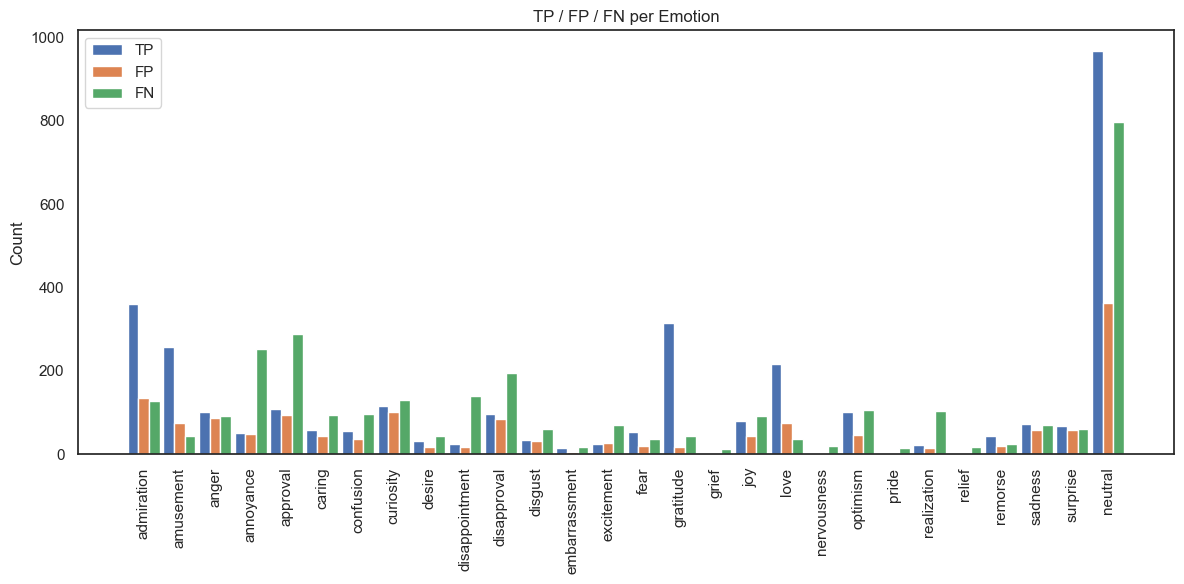

In [62]:
TP = ((labels == 1) & (preds == 1)).sum(axis=0)
FP = ((labels == 0) & (preds == 1)).sum(axis=0)
FN = ((labels == 1) & (preds == 0)).sum(axis=0)

x = np.arange(len(label_names))
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x - width, TP, width, label='TP')
plt.bar(x, FP, width, label='FP')
plt.bar(x + width, FN, width, label='FN')

plt.xticks(x, label_names, rotation=90)
plt.ylabel("Count")
plt.title("TP / FP / FN per Emotion")
plt.legend()
plt.tight_layout()
plt.show()


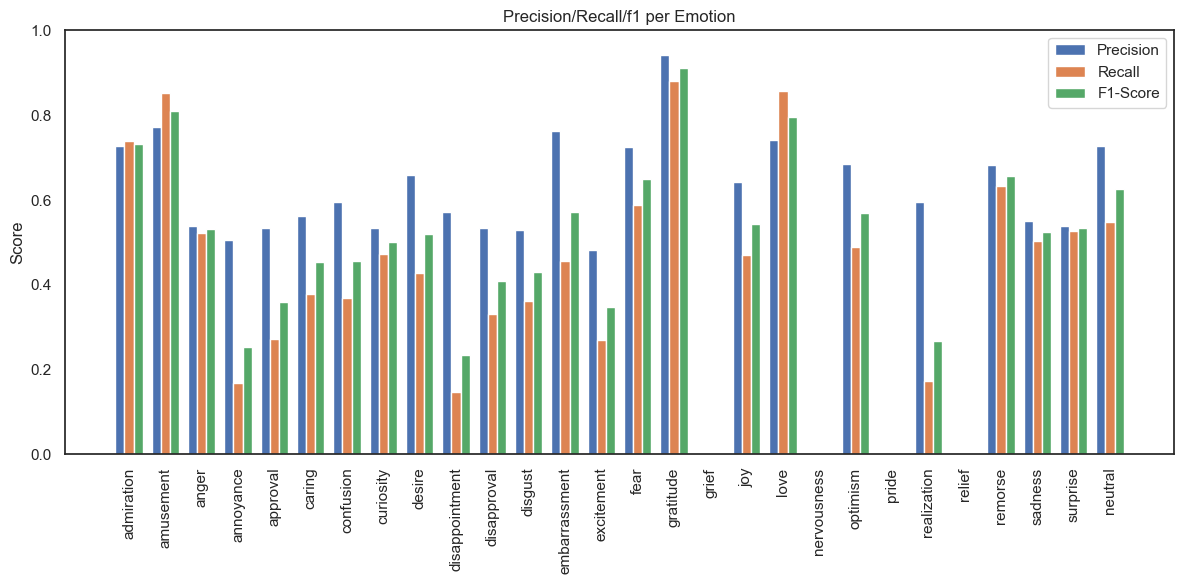

In [ ]:
report=classification_report(
    labels,
    preds,
    target_names=label_names,
    zero_division=0,
    output_dict=True
)
precision=[report[name]["precision"] for name in label_names]
recall=[report[name]["recall"]    for name in label_names]
f1= [report[name]["f1-score"]  for name in label_names]

x=np.arange(len(label_names))
width=0.25
plt.figure(figsize=(12,6))


plt.bar(x-width,precision,width,label='Precision')
plt.bar(x,recall,width,label='Recall')
plt.bar(x+width,f1,width,label='F1-Score')

plt.xticks(x, label_names)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Precision/Recall/f1 per Emotion")
plt.legend()
plt.tight_layout()
plt.show()

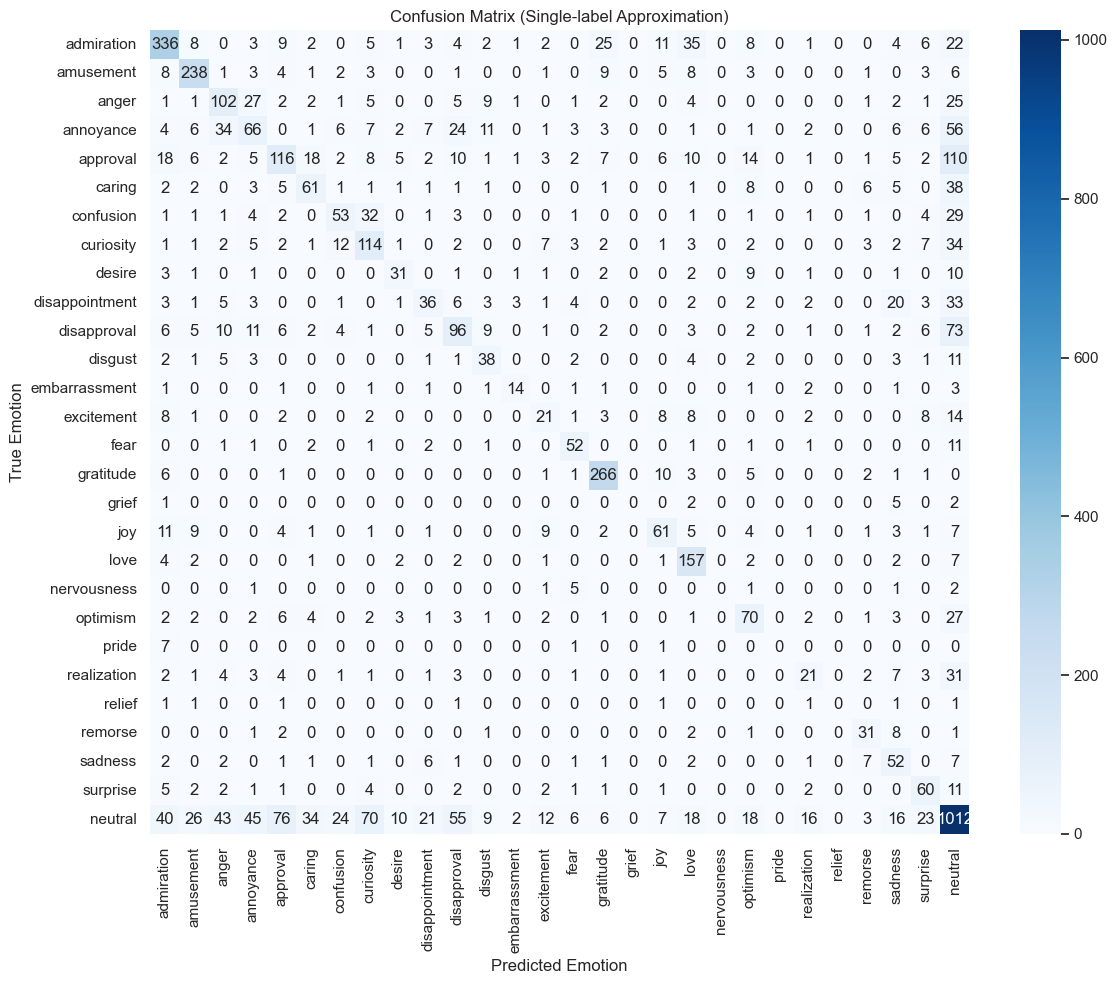

In [ ]:
# predicted class = highest probability
pred_single = np.argmax(probs, axis=1)

# true class = the label whose value = 1
true_single = np.argmax(labels, axis=1)
cm = confusion_matrix(true_single, pred_single)
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)

plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Confusion Matrix (Single-label Approximation)")
plt.tight_layout()
plt.show()


In [81]:
print(np.corrcoef(labels.T))

[[ 1.00000000e+00 -5.96197971e-02 -5.72350291e-02 -7.08418118e-02
  -1.16393651e-02 -4.18744068e-02 -4.94647014e-02 -4.72069001e-02
  -1.59317888e-02 -2.89068319e-02 -6.64074009e-02 -3.26894991e-02
  -2.53299145e-02 -1.77573513e-02 -2.56953681e-02 -5.12683706e-04
  -2.22928984e-03 -1.72529629e-03  1.02789662e-03 -1.95950405e-02
  -1.27098483e-02 -1.65516476e-02 -3.16241546e-02 -1.81364498e-02
  -2.96242188e-02 -3.56345010e-02 -2.79160864e-02 -2.03244631e-01]
 [-5.96197971e-02  1.00000000e+00 -3.83310854e-02 -4.16673914e-02
  -4.67549678e-02 -3.17289636e-02 -1.69661572e-02 -3.01645527e-02
  -2.91788519e-02 -2.86931559e-02 -2.95437375e-02 -2.06963655e-02
  -1.95955967e-02 -2.19699958e-03 -3.15843891e-02 -3.55381099e-02
  -1.19182310e-02  1.09727871e-02 -1.93456362e-02 -1.51590133e-02
  -2.78231005e-02 -1.28045995e-02 -1.64146638e-02 -1.40306260e-02
  -2.01825132e-02 -3.50011061e-02 -3.26838855e-02 -1.48376642e-01]
 [-5.72350291e-02 -3.83310854e-02  1.00000000e+00  1.64336592e-01
  -4.664

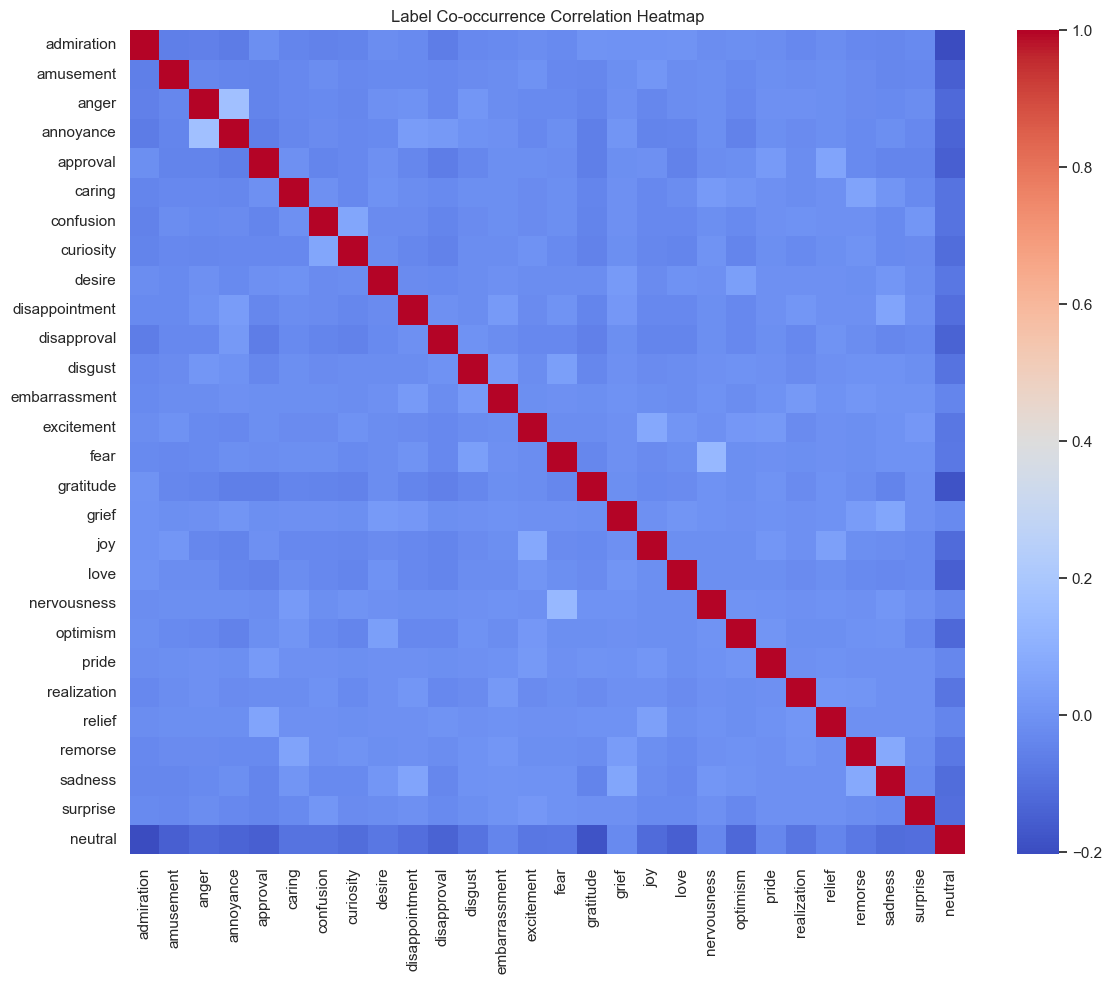

In [ ]:
corr = np.corrcoef(labels.T)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, xticklabels=label_names, yticklabels=label_names, cmap="coolwarm")
plt.title("Label Co-occurrence Correlation Heatmap")
plt.tight_layout()
plt.show()


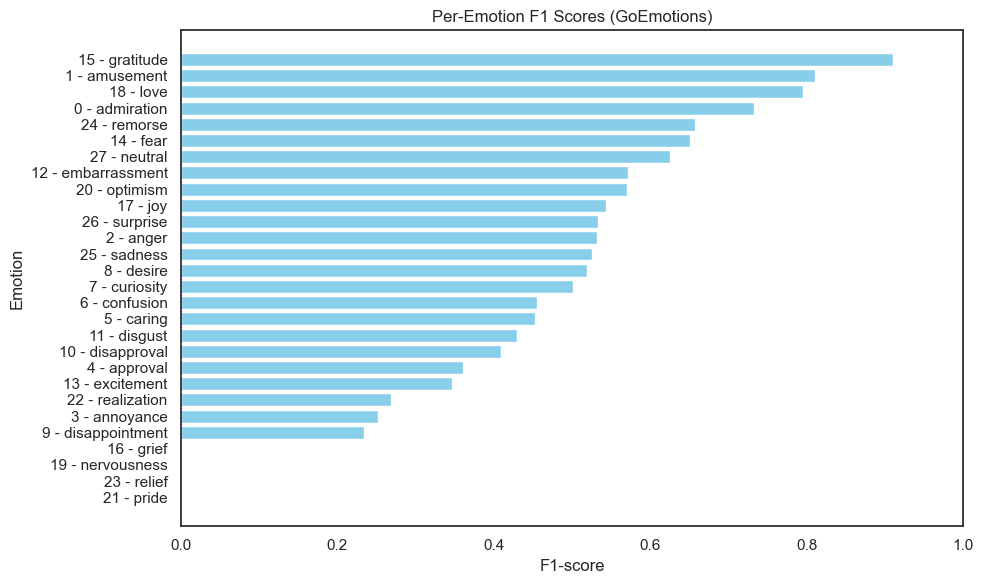

In [69]:
# Ensure labels & preds are int numpy arrays
labels = labels.astype(int)
preds = preds.astype(int)

# Get the full classification report as a dict
report = classification_report(
    labels, preds,
    target_names=target_names,
    zero_division=0,
    output_dict=True
)

# Extract per-class F1 scores
f1_scores = [report[name]["f1-score"] for name in target_names]

# Sort classes by F1 for a cleaner plot
sorted_idx = np.argsort(f1_scores)
sorted_names = np.array(target_names)[sorted_idx]
sorted_scores = np.array(f1_scores)[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_scores, color="skyblue")
plt.title("Per-Emotion F1 Scores (GoEmotions)")
plt.xlabel("F1-score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

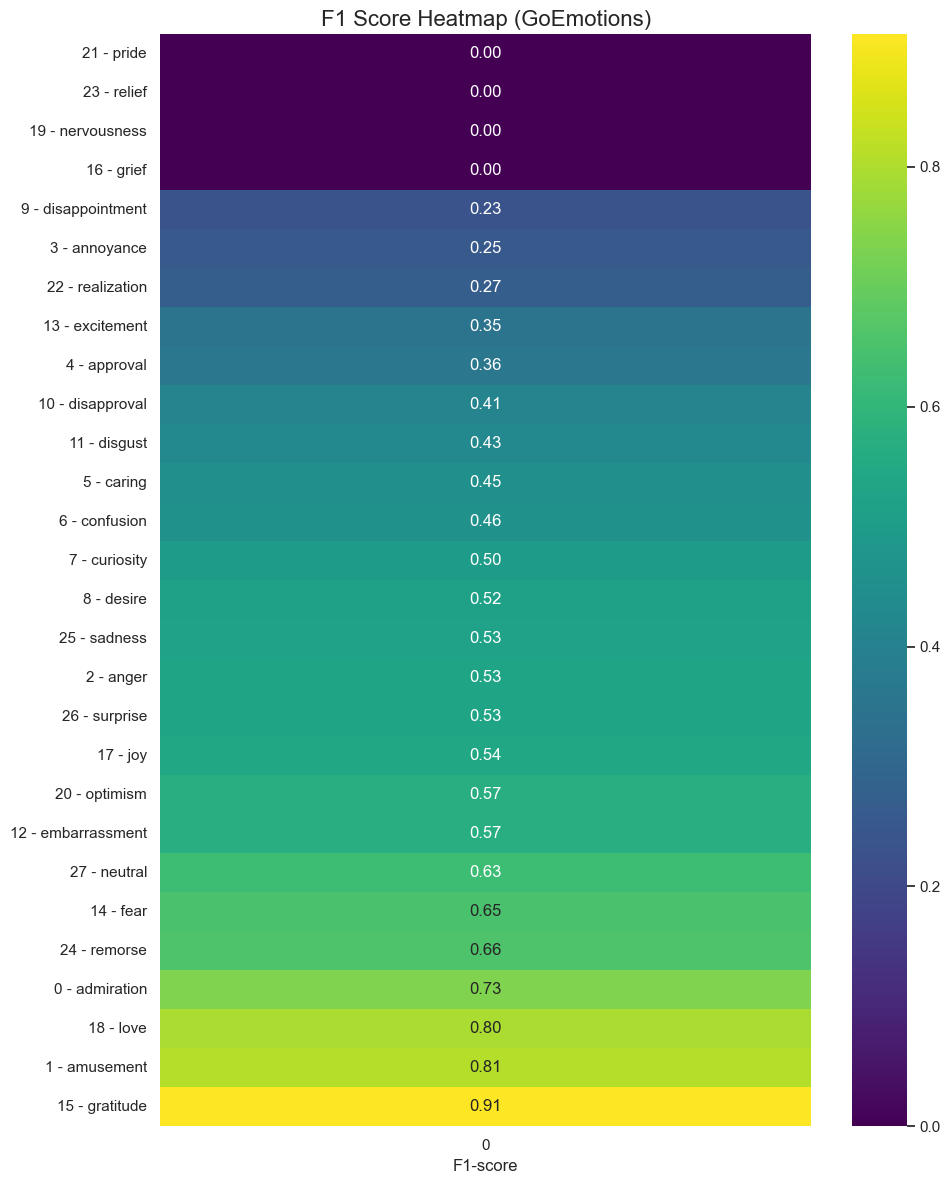

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

scores = np.array(f1_scores)
names = np.array(target_names)

# Sort
idx = np.argsort(scores)
scores = scores[idx]
names = names[idx]

plt.figure(figsize=(10, 12))
sns.heatmap(scores.reshape(-1,1), annot=True, fmt=".2f",
            cmap="viridis", yticklabels=names, cbar=True)
plt.title("F1 Score Heatmap (GoEmotions)", fontsize=16)
plt.xlabel("F1-score")
plt.tight_layout()
plt.show()
